# ACOM Tutorial Notebook - Overlapping Patterns

In this tutorial, we will test the ability of the py4DSTEM ACOM module to handle overlapping patterns.

### Acknowledgements

This tutorial notebook was written by Colin Ophus. Contact clophus@lbl.gov with any questions.

### Versioning

Last updated on 2022-01-13 with py4DSTEM v.0.12.10

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import py4DSTEM
import numpy as np

In [3]:
# Define gold structure
pos = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.5, 0.5],
    [0.5, 0.0, 0.5],
    [0.5, 0.5, 0.0],
])
atom_num = 79
a = 4.08
cell = a

# cell np.array([a,b,c,90,90,120])

crystal = py4DSTEM.process.diffraction.Crystal(
    pos, 
    atom_num, 
    cell)

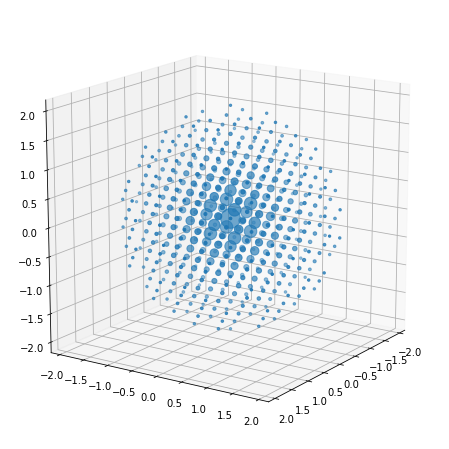

In [4]:
crystal.calculate_structure_factors(2.0)
crystal.plot_structure_factors(proj_dir=[3,2,1])

### Testing orientation matching

In [30]:
# For this orientation plan, we reduce the tolerance for peak deletion,
# since we expect Bragg peaks that are very close together (due to the overlapping peaks).

crystal.orientation_plan(
    angle_step_zone_axis = 1.0,
    angle_step_in_plane = 2.0,
    # accel_voltage = 300e3,
    # intensity_power=0.25,
    tol_peak_delete=0.02,
    corr_kernel_size=0.12,
)

Orientation plan: 100%|████████████████████████████████████████████████████| 1596/1596 [00:27<00:00, 58.97 zone axes/s]


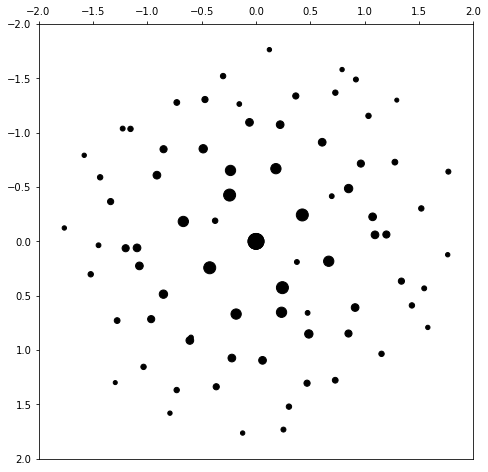

[0. 0. 1.] 
 [0.218 0.436 0.873] 
 [0.302 0.302 0.905]


In [31]:
# Define z set of zone axes, and in-plane x axes projection vectors

za1 = np.array([0,0,1])
za2 = np.array([1,2,4])
za3 = np.array([1,1,3])
xp1 = np.array([ 0.3594,   -0.205,   0.4187])
xp2 = np.array([-0.1088,    0.3102,   0.5094])
xp3 = np.array([-0.4479,    0.2926,  -0.6748])

t1 = np.round(za1/np.linalg.norm(za1),decimals=3)
t2 = np.round(za2/np.linalg.norm(za2),decimals=3)
t3 = np.round(za3/np.linalg.norm(za3),decimals=3)

bragg_peaks_01 = crystal.generate_diffraction_pattern(
    zone_axis = za1,
    proj_x_axis = xp1,
    sigma_excitation_error=0.02)
bragg_peaks_02 = crystal.generate_diffraction_pattern(
    zone_axis = za2,
    proj_x_axis = xp2,
    sigma_excitation_error=0.02)
bragg_peaks_03 = crystal.generate_diffraction_pattern(
    zone_axis = za3,
    proj_x_axis = xp3,
    sigma_excitation_error=0.02)

bragg_peaks = py4DSTEM.io.datastructure.PointList([
    ('qx','float64'),
    ('qy','float64'),
    ('intensity','float64'),
    ('h','int'),
    ('k','int'),
    ('l','int')])
bragg_peaks.add_pointlist(bragg_peaks_01)
bragg_peaks.add_pointlist(bragg_peaks_02)
bragg_peaks.add_pointlist(bragg_peaks_03)

fig,ax = py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks,
    add_labels=False,
    plot_range_kx_ky=[2,2],
    figsize=(8,8),
    returnfig=True,
)
print(t1,'\n',t2,'\n',t3)

In [32]:
# Save the combined diffraction pattern
# fig.savefig('multi_pattern_001_113_124.pdf')

In [33]:
orientation = crystal.match_single_pattern(
    bragg_peaks,
    num_matches_return = 3,
    verbose=True,
)

Best fit zone axis = ([-0. -0.  1.]) with corr value = 3.958
Best fit zone axis = ([0.212 0.463 0.86 ]) with corr value = 2.771
Best fit zone axis = ([0.297 0.297 0.907]) with corr value = 1.794


In [29]:
# Compare the input and output zone axes

# estimate integer scaling for output zones - note we change the order for this comparison
za1_fit = orientation.matrix[0,:,2]
za2_fit = orientation.matrix[1,:,2]
za3_fit = orientation.matrix[2,:,2]
v1 = za1_fit[np.abs(za1_fit)>0.1]
v2 = za2_fit[np.abs(za2_fit)>0.1]
v3 = za3_fit[np.abs(za3_fit)>0.1]
ind1 = np.argmin(np.abs(v1))
ind2 = np.argmin(np.abs(v2))
ind3 = np.argmin(np.abs(v3))
za1_fit = np.round(za1_fit / v1[ind1],decimals=2)
za2_fit = np.round(za2_fit / v2[ind2],decimals=2)
za3_fit = np.round(za3_fit / v3[ind3],decimals=2)
# za2_fit = np.round(za2_fit / np.min(za2_fit[np.abs(za2_fit)>0.1]),decimals=2)
# za3_fit = np.round(za3_fit / np.min(za3_fit[np.abs(za3_fit)>0.1]),decimals=2)

print('')
print('zone axis 1 -> ' + str(za1) + ', fitted to ' + str(za1_fit))
print('zone axis 2 -> ' + str(za2) + ', fitted to ' + str(za2_fit))
print('zone axis 3 -> ' + str(za3) + ', fitted to ' + str(za3_fit))
print('')



zone axis 1 -> [0 0 1], fitted to [0. 0. 1.]
zone axis 2 -> [1 2 4], fitted to [1.   2.19 3.97]
zone axis 3 -> [1 1 3], fitted to [1.   1.1  3.11]



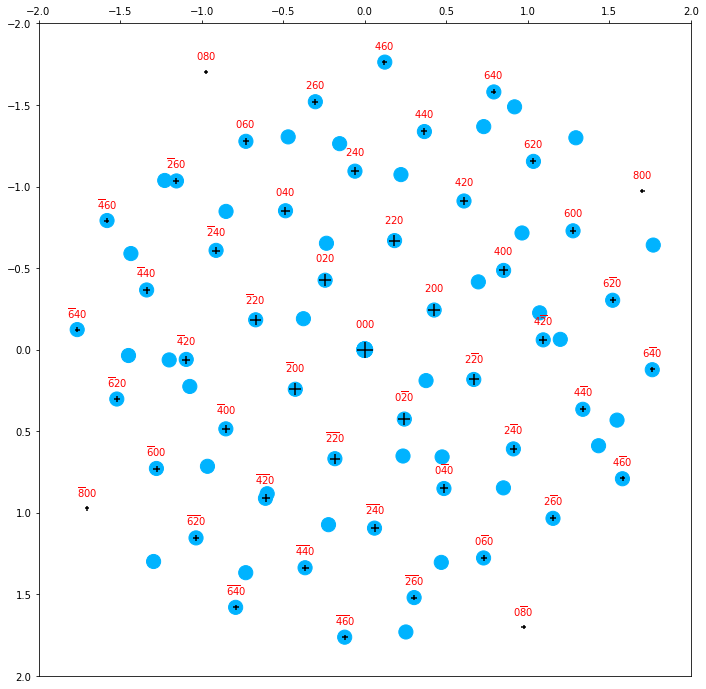

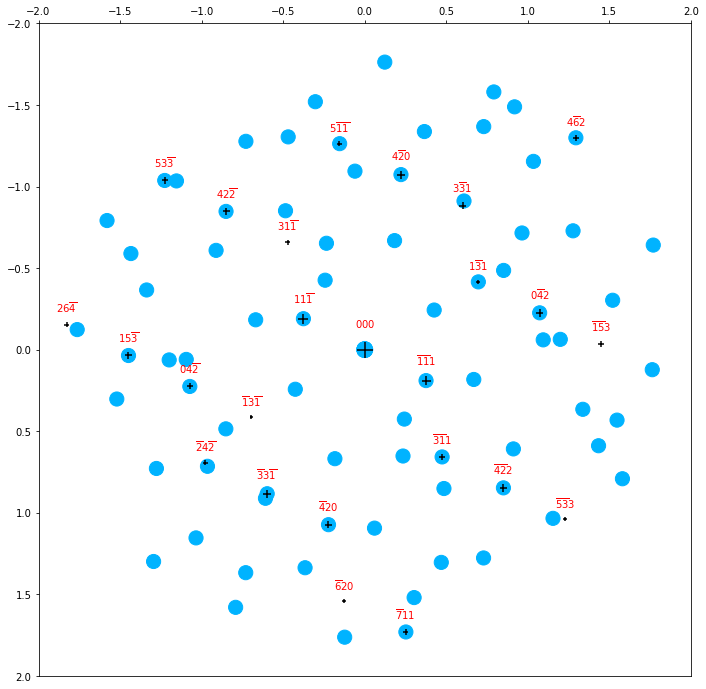

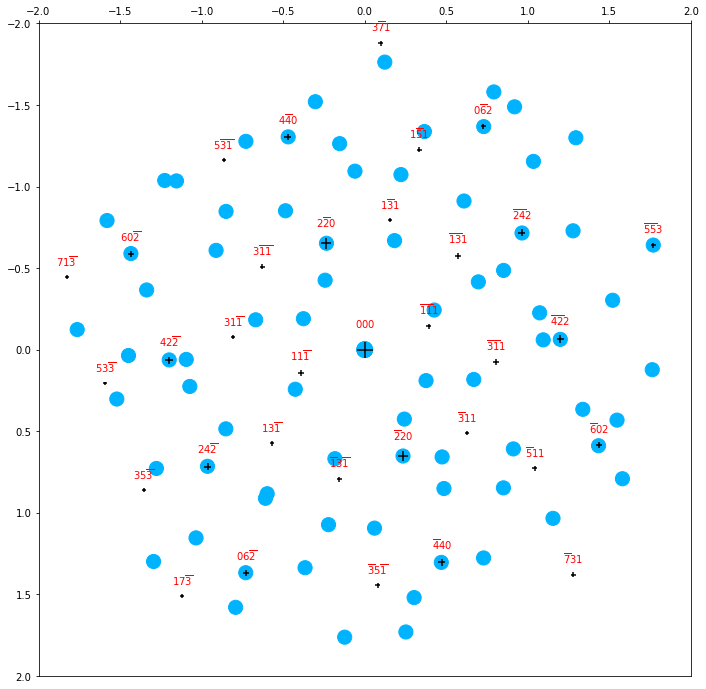

In [40]:
# Plot all of the matches overlaid over all peaks

for a0 in range(orientation.num_matches):
    bragg_peaks_fit = crystal.generate_diffraction_pattern(
        orientation,
        ind_orientation = a0,
        sigma_excitation_error=0.03
    )
    
    fig,ax = py4DSTEM.process.diffraction.plot_diffraction_pattern(
        bragg_peaks_fit,
        bragg_peaks_compare=bragg_peaks,
        plot_range_kx_ky=[2,2],
        min_marker_size=200,
        figsize=(12,12),
        returnfig=True,
    )

In [41]:
# fig.savefig('multi_fit_patterns.pdf')